# Multi-Class Prediction of Cirrhosis Outcomes with Deep Learning

<img src='https://post.healthline.com/wp-content/uploads/2022/01/1926368-Cirrhosis_1296x728-body.png' style='width:600px;'>

<p style="color:#85C1E9"><b>What is cirrhosis</b></p>

Cirrhosis is a late stage of scarring of the liver caused by many forms of liver diseases and conditions. It impairs liver functions and can lead to serious complications

<p style="color:#85C1E9"><b>Status (Target variable)</b></p>

Target value consists three different classes
1. <b>Status_C : </b>C stands for censored indicates the patient was alive after N_Days.
1. <b>Status_CL : </b>CL indicates that the patient was alive after N_Days due to a liver transplant.
1. <b>Status_D : </b>patient was deceased after N_Days.

<img src='https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2003977%2F4465d9311ccae2f9ccb057fc7e14f26f%2FScreenshot%20from%202023-10-18%2009-42-52.png?generation=1697586187040332&alt=media' style='width:600px;'>

## 🛠️ 1. Load packages

In [51]:
!pip install optuna

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import optuna

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb

!pip install scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor

## 💾 2. Importing the data

In [53]:
train = pd.read_csv('train.csv').set_index('id')
test = pd.read_csv('test.csv').set_index('id')
sample = pd.read_csv('sample_submission.csv')

#original dataset to improve training
orig = pd.read_csv('cirrhosis.csv').set_index('ID')

#### Impute original dataset

The original dataset has some missing values

In [54]:
print(orig.isna().sum())

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64


In [55]:
imputer = SimpleImputer(strategy="mean")

fitfloat = orig.select_dtypes(float).columns
orig[fitfloat] = imputer.fit_transform(orig[fitfloat])

orig = orig[orig['Drug'].notnull()]

In [56]:
print(orig.isna().sum())

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [57]:
train = pd.concat([train, orig], axis=0).reset_index(drop=True)

**Train dataset entries :** 7905<br>
**Train + Original dataset entries :** 8217

<h4>Increasing of +4%</h4>

In [58]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

df.head().style.background_gradient(cmap='Blues')

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.300000,316.000000,3.350000,172.000000,1601.000000,179.800000,63.000000,394.000000,9.700000,3.000000,D
1,2574,Placebo,19237,F,N,N,N,N,0.900000,364.000000,3.540000,63.000000,1440.000000,134.850000,88.000000,361.000000,11.000000,3.000000,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.300000,299.000000,3.550000,131.000000,1029.000000,119.350000,50.000000,199.000000,11.700000,4.000000,D
3,2576,Placebo,18460,F,N,N,N,N,0.600000,256.000000,3.500000,58.000000,1653.000000,71.300000,96.000000,269.000000,10.700000,3.000000,C
4,788,Placebo,16658,F,N,Y,N,N,1.100000,346.000000,3.650000,63.000000,1181.000000,125.550000,96.000000,298.000000,10.600000,4.000000,C


## ⚙️ 3. Feature Engineering

<h4 style="color:#85C1E9"><b>Thrombocytopenia</b></h4>
<div class="alert alert-block alert-info">
Thrombocytopenia is a condition that occurs when the platelet count in your blood is too low</div>

In [59]:
threshold_platelets = 150
df['Thrombocytopenia'] = np.where(df['Platelets'] < threshold_platelets, 1, 0)

<h4 style="color:#85C1E9"><b>Cholesterol</b></h4>
<div class="alert alert-block alert-info">
A total cholesterol level of less than 200 mg/dL is normal.<br>A total cholesterol level of 200 to 239 mg/dL is borderline high.<br>A total cholesterol level of 240 mg/dL or greater is high.</div>

In [60]:
treshold_cholesterol = 240
df['High_cholesterol'] = np.where(df['Cholesterol'] > treshold_cholesterol, 1, 0)

<h4 style="color:#85C1E9"><b>Albumin</b></h4>
<div class="alert alert-block alert-info">
A normal albumin range is 3.4 to 5.4 g/dL. If you have a lower albumin level, you may have malnutrition.</div>

In [61]:
normal_albumin_range = (3.4, 5.4) #3.5 - 5
df['Normal_albumin'] = np.where((df['Albumin'] >= normal_albumin_range[0]) & (df['Albumin'] <= normal_albumin_range[1]), 1, 0)

<h4 style="color:#85C1E9"><b>Bilirubin</b></h4>
<div class="alert alert-block alert-info">
It is normal to have some bilirubin in the blood. A normal level is 0.1 to 1.2 mg/dL</div>

In [62]:
normal_bilirubin_range = (0.2, 1.2)
df['Normal_bilirubin'] = np.where((df['Bilirubin'] >= normal_bilirubin_range[0]) & (df['Bilirubin'] <= normal_bilirubin_range[1]), 1, 0)

<h4 style="color:#85C1E9"><b>Prothrombin Time</b></h4>
<div class="alert alert-block alert-info">
In most laboratories, the normal range for PT is 10 to 13 seconds.</div>

In [63]:
normal_p_time = (10, 13)
df['Normal_p_time'] = np.where((df['Prothrombin'] >= normal_p_time[0]) & (df['Prothrombin'] <= normal_p_time[1]), 1, 0)

<h4 style="color:#85C1E9"><b>Copper Levels</b></h4>
<div class="alert alert-block alert-info">
The normal range for total copper in the blood is 63.7 to 140.12 micrograms per deciliter (mcg/dL)</div>

In [64]:
normal_copper_range = (63.7, 140.12)
df['Normal_copper'] = np.where((df['Copper'] >= normal_copper_range[0]) & (df['Copper'] <= normal_copper_range[1]), 1, 0)

<h4 style="color:#85C1E9"><b>Bilirubin-Albumin Ratio</b></h4>
<div class="alert alert-block alert-info">
Bilirubin/albumin ratio (B/A) may provide a better estimate of free bilirubin than total serum bilirubin (TSB), thus improving identification of newborns at risk for bilirubin encephalopathy.</div>

In [65]:
df['Bilirubin_Albumin'] = df['Bilirubin'] / df['Albumin']

<h4 style="color:#85C1E9"><b>Model for End-Stage Liver Disease</b></h4>
<div class="alert alert-block alert-info">
MELD uses the patient's values for serum bilirubin, serum creatinine, and the international normalized ratio for prothrombin time (INR) to predict survival.</div>

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/1d47d5bfbf38c395d1213f3fb83c67f890540254'>

In [66]:
df['MELD_score_component'] = 3.78 * np.log(df['Bilirubin']) + 11.2 * 1.3 * np.log(df['Prothrombin']) + 6.43

<h4 style="color:#85C1E9"><b>Time Features</b></h4>

In [67]:
year = 365.25

df['Age_in_year'] = (df['Age'] / year).astype(int)
df['N_Month'] = ((df['N_Days'] % year) / 30).astype(int)
df['N_Years'] = (df['N_Days'] / year).astype(int)

<h4 style="color:#85C1E9"><b>N_days</b></h4>
<div class="alert alert-block alert-info">
Only 94 patients who survived have N_days < 769, whereas 666 of the patients who died have N_days below 769. We will use this as a feature.</div>

In [68]:
df['N_Days_under_769'] = np.where(df['N_Days'] < 769, 1, 0)

<h4 style="color:#85C1E9"><b>Age Groups</b></h4>

**Minimal Age:** 25 <br>
**Maximal Age:** 78

In [69]:
age_range = (df.Age_in_year.min()-1, df.Age_in_year.max())
df['Age_Group'] = pd.cut(df['Age_in_year'], bins=[age_range[0], 39, 64, age_range[1]], labels = [0, 1, 2]).astype('int16')

In [70]:
display(df.head().style.background_gradient(cmap='Blues'))

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Thrombocytopenia,High_cholesterol,Normal_albumin,Normal_bilirubin,Normal_p_time,Normal_copper,Bilirubin_Albumin,MELD_score_component,Age_in_year,N_Month,N_Years,N_Days_under_769,Age_Group
0,999,D-penicillamine,21532,M,N,N,N,N,2.300000,316.000000,3.350000,172.000000,1601.000000,179.800000,63.000000,394.000000,9.700000,3.000000,D,0,1,0,0,0,0,0.686567,42.660549,58,8,2,0,1
1,2574,Placebo,19237,F,N,N,N,N,0.900000,364.000000,3.540000,63.000000,1440.000000,134.850000,88.000000,361.000000,11.000000,3.000000,C,0,1,1,1,1,0,0.254237,40.945092,52,0,7,0,1
2,3428,Placebo,13727,F,N,Y,Y,Y,3.300000,299.000000,3.550000,131.000000,1029.000000,119.350000,50.000000,199.000000,11.700000,4.000000,D,0,1,1,0,1,1,0.929577,46.754640,37,4,9,0,0
3,2576,Placebo,18460,F,N,N,N,N,0.600000,256.000000,3.500000,58.000000,1653.000000,71.300000,96.000000,269.000000,10.700000,3.000000,C,0,1,1,1,1,0,0.171429,39.009828,50,0,7,0,1
4,788,Placebo,16658,F,N,Y,N,N,1.100000,346.000000,3.650000,63.000000,1181.000000,125.550000,96.000000,298.000000,10.600000,4.000000,C,0,1,1,1,1,0,0.301370,41.164307,45,1,2,0,1


## 📊 4. EDA

In [71]:
num_cols = df.select_dtypes(include = ['float64', 'int64', 'int16']).columns
cat_cols = df.select_dtypes(include = ['O']).columns

In [72]:
df[num_cols].describe().style.background_gradient('Blues')

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Thrombocytopenia,High_cholesterol,Normal_albumin,Normal_bilirubin,Normal_p_time,Normal_copper,Bilirubin_Albumin,MELD_score_component,Age_in_year,N_Month,N_Years,N_Days_under_769,Age_Group
count,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000,13488.000000
mean,2032.953366,18419.444321,2.612096,351.752320,3.543661,84.532981,1818.429018,114.391074,115.535592,264.680316,10.633017,3.034253,0.088820,0.795744,0.698399,0.555308,0.782251,0.351349,0.782932,42.259427,49.924600,5.588894,5.066133,0.101720,0.901839
std,1091.966426,3647.433512,3.847397,198.007394,0.351488,76.796212,1921.938476,49.070388,52.809066,87.689211,0.791925,0.862634,0.284494,0.403172,0.458970,0.496950,0.412731,0.477410,1.223964,4.109438,9.986735,3.532701,3.021426,0.302291,0.467053
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068182,34.347992,26.000000,0.000000,0.000000,0.000000,0.000000
25%,1230.000000,15612.000000,0.700000,248.000000,3.350000,39.000000,824.000000,75.950000,84.000000,210.000000,10.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.193906,39.257033,42.000000,3.000000,3.000000,0.000000,1.000000
50%,1874.000000,18719.000000,1.100000,299.000000,3.580000,64.000000,1166.000000,106.965000,104.000000,264.000000,10.600000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.302198,40.812123,51.000000,5.000000,5.000000,0.000000,1.000000
75%,2689.750000,20684.000000,3.000000,390.000000,3.770000,102.000000,1840.000000,137.950000,139.000000,316.000000,11.000000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.851232,44.955188,56.000000,9.000000,7.000000,0.000000,1.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.859155,58.294266,78.000000,12.000000,13.000000,1.000000,2.000000


<div style="background-color: #F2F3F4; padding: 10px; border-radius: 10px;">
    <p style="font-size: 20px; font-family: 'Verdana'; color: #3A405A; text-align: center;">Data Summary</p>
    <p style="font-size: 16px; font-family: 'Verdana'; text-align: center;">
        <b>Total Number of Variables: </b>32<br>
        <b>Total Number of Rows:</b> 13488<br>
        <b>Missing Values:</b> None (All variables have 0 missing values)<br>
        <b>Target Variable:</b> 'Status' (Multi-Class)
    </p>
</div>

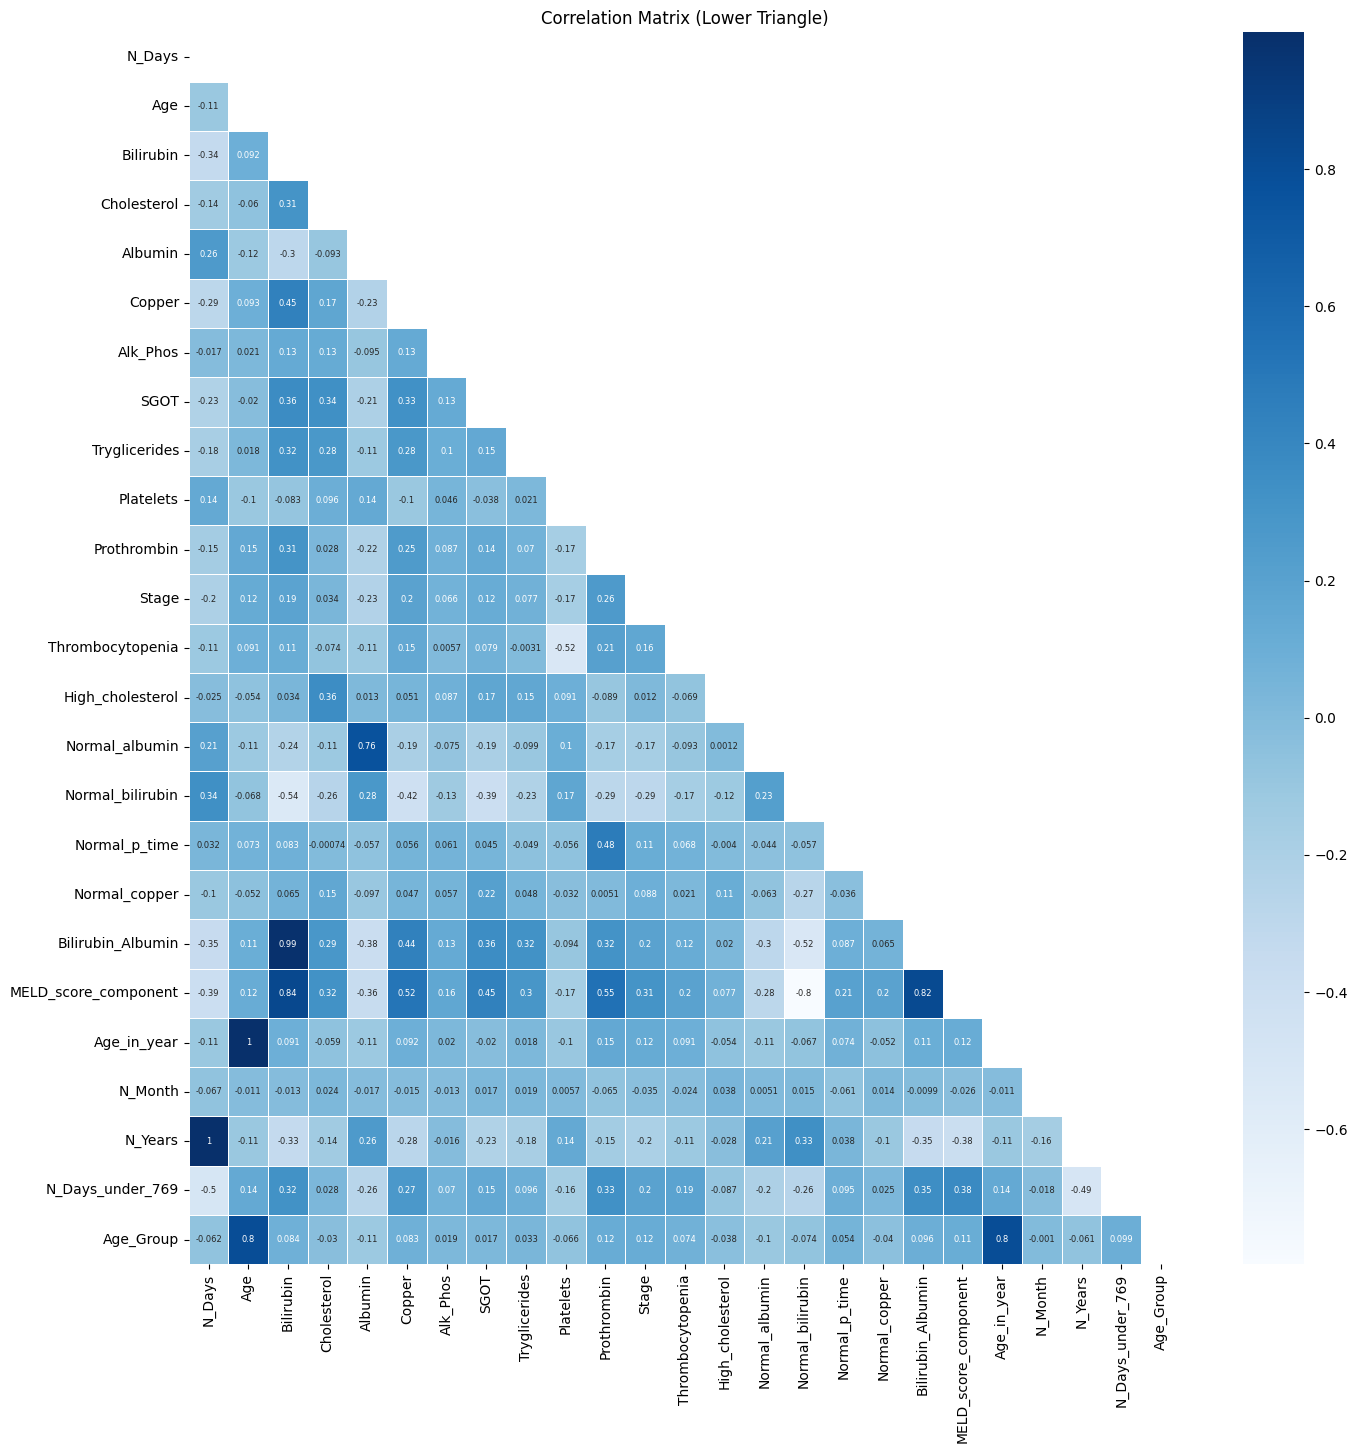

In [73]:
corr = df.select_dtypes('number').corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(16, 16))
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='Blues', annot=True, annot_kws={'size': 6})
plt.title('Correlation Matrix (Lower Triangle)')
plt.show()

* **N_Days** is correlated to **N_Years** (1)
* **Age_in_year** is correlated to **Age** (1)
* **Bilirubin_Albumin** is correlated to **Bilirubin** (0.99)

<blockquote>To avoid multicollinearity, there must be no linear dependence between the predictors; this is the case, for example, when one variable is the multiple of another variable.</blockquote>

In [74]:
df = df.drop(['N_Days', 'Age', 'Bilirubin_Albumin'], axis=1)

## ✏️ 5. Preprocessing

In [75]:
numeric_cols= df.select_dtypes('number').columns.to_list()
numeric_cols.remove('Stage')

train = df.iloc[:len(train)]
test = df.iloc[len(train):]

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

test_to_scale = test[numeric_cols]
train_to_scale = train[numeric_cols]

In [76]:
rs = RobustScaler()

train_scaled = pd.DataFrame(rs.fit_transform(train_to_scale), columns=train_to_scale.columns)
test_scaled = pd.DataFrame(rs.transform(test_to_scale), columns=test_to_scale.columns)

In [77]:
train_ohe = train.drop(numeric_cols, axis =1)
test_ohe = test.drop(numeric_cols, axis =1).drop("Status", axis=1)

In [78]:
cols = train_ohe.columns.tolist()
cols.remove('Status')

ohe_train = pd.get_dummies(train_ohe, columns=cols)
ohe_test  = pd.get_dummies(test_ohe, columns=cols)

ohe_train = ohe_train.replace({True: 1, False: 0})
ohe_test = ohe_test.replace({True: 1, False: 0})

In [79]:
train = pd.concat([ohe_train, train_scaled], axis =1)
test = pd.concat([ohe_test, test_scaled], axis =1)

In [80]:
le = LabelEncoder()
train['Status'] = le.fit_transform(train['Status'])

### Final Datasets

In [81]:
display(train.head().style.background_gradient(cmap='Blues'))
display(test.head().style.background_gradient(cmap='Blues'))

,Status,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Thrombocytopenia,High_cholesterol,Normal_albumin,Normal_bilirubin,Normal_p_time,Normal_copper,MELD_score_component,Age_in_year,N_Month,N_Years,N_Days_under_769,Age_Group
0,2,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0.521739,0.119718,-0.547619,1.730159,0.410557,1.150000,-0.745455,1.216981,-0.900000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.310520,0.500000,0.500000,-0.750000,0.000000,0.000000
1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,-0.086957,0.457746,-0.095238,0.000000,0.253177,0.425000,-0.290909,0.905660,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010177,0.071429,-0.833333,0.500000,0.000000,0.000000
2,2,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0.956522,0.000000,-0.071429,1.079365,-0.148583,0.175000,-0.981818,-0.622642,1.100000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,1.027315,-1.000000,-0.166667,1.000000,0.000000,-1.000000
3,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,-0.217391,-0.302817,-0.190476,-0.079365,0.461388,-0.600000,-0.145455,0.037736,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.328650,-0.071429,-0.833333,0.500000,0.000000,0.000000
4,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0.000000,0.330986,0.166667,0.000000,0.000000,0.275000,-0.145455,0.311321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048557,-0.428571,-0.666667,-0.750000,0.000000,0.000000


,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Thrombocytopenia,High_cholesterol,Normal_albumin,Normal_bilirubin,Normal_p_time,Normal_copper,MELD_score_component,Age_in_year,N_Month,N_Years,N_Days_under_769,Age_Group
0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0.043478,1.739437,-0.500000,0.031746,0.444770,0.700000,-0.254545,1.556604,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.106142,0.214286,0.166667,1.250000,0.000000,0.000000
1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0.000000,2.542254,1.523810,0.492063,0.074291,0.700000,0.927273,-0.358491,-0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.099980,-0.785714,0.666667,0.250000,0.000000,0.000000
2,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0.391304,-1.042254,-1.476190,-0.269841,-0.215054,-0.625000,-0.054545,-0.490566,2.400000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.964482,-1.071429,-0.666667,-1.250000,1.000000,-1.000000
3,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,-0.217391,-0.042254,0.642857,-0.365079,-0.612903,0.275000,-0.872727,0.047170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.352586,0.357143,-0.166667,0.250000,0.000000,0.000000
4,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0.130435,-0.154930,-1.452381,0.920635,-0.069404,0.266129,0.400000,-0.415094,-0.800000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,1.000000,0.008122,0.571429,0.000000,-0.250000,0.000000,0.000000


In [82]:
X = train.drop("Status", axis=1)
y = train["Status"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

num_classes = 3

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

## 🤖 6. Predictive model

### 1. Deep Learning

In [83]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True)
]

In [84]:
def create_nn_model(num_neurons=32, learning_rate=1.0e-05, act='swish', dropout=0.3):
    model = Sequential()


    model.add(Dense(num_neurons, activation=act, input_dim=X_train.shape[1]))
    model.add(BatchNormalization())

    model.add(Dense(num_neurons, activation=act))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_neurons, activation=act))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(int(num_neurons//2), activation=act))
    model.add(BatchNormalization())

    model.add(Dense(int(num_neurons//4), activation=act))
    model.add(BatchNormalization())

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

    return model

In [85]:
model = create_nn_model()

history = model.fit(X_train, y_train, callbacks=callbacks_list, epochs=500, batch_size=16, validation_split=0.2)

Epoch 1/500
370/370 [==============================] - 8s 11ms/step - loss: 0.8560 - accuracy: 0.6575 - val_loss: 0.5839 - val_accuracy: 0.7890
Epoch 2/500
370/370 [==============================] - 6s 16ms/step - loss: 0.6260 - accuracy: 0.7688 - val_loss: 0.5374 - val_accuracy: 0.8012
Epoch 3/500
370/370 [==============================] - 5s 14ms/step - loss: 0.5876 - accuracy: 0.7711 - val_loss: 0.5191 - val_accuracy: 0.8005
Epoch 4/500
370/370 [==============================] - 5s 15ms/step - loss: 0.5621 - accuracy: 0.7821 - val_loss: 0.5082 - val_accuracy: 0.8066
Epoch 5/500
370/370 [==============================] - 6s 17ms/step - loss: 0.5556 - accuracy: 0.7828 - val_loss: 0.5037 - val_accuracy: 0.8107
Epoch 6/500
370/370 [==============================] - 6s 17ms/step - loss: 0.5536 - accuracy: 0.7841 - val_loss: 0.5021 - val_accuracy: 0.8093
Epoch 7/500
370/370 [==============================] - 5s 13ms/step - loss: 0.5503 - accuracy: 0.7836 - val_loss: 0.4994 - val_accuracy:

26/26 [==============================] - 0s 2ms/step
Test set log loss: 0.4619070397004159
min of val log loss:  0.47717249393463135


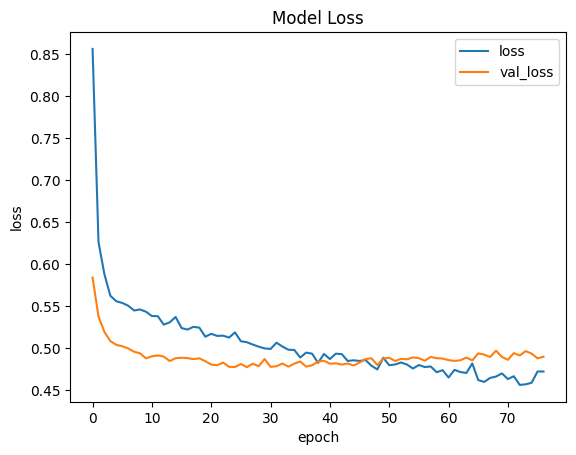

In [86]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title='Model Loss', xlabel='epoch', ylabel='loss')


preds = model.predict(X_val)
val_loss = log_loss(y_val_cat, preds)
print(f"Test set log loss: {val_loss}")
print("min of val log loss: ", min(history_df['val_loss']))

165/165 [==============================] - 0s 2ms/step


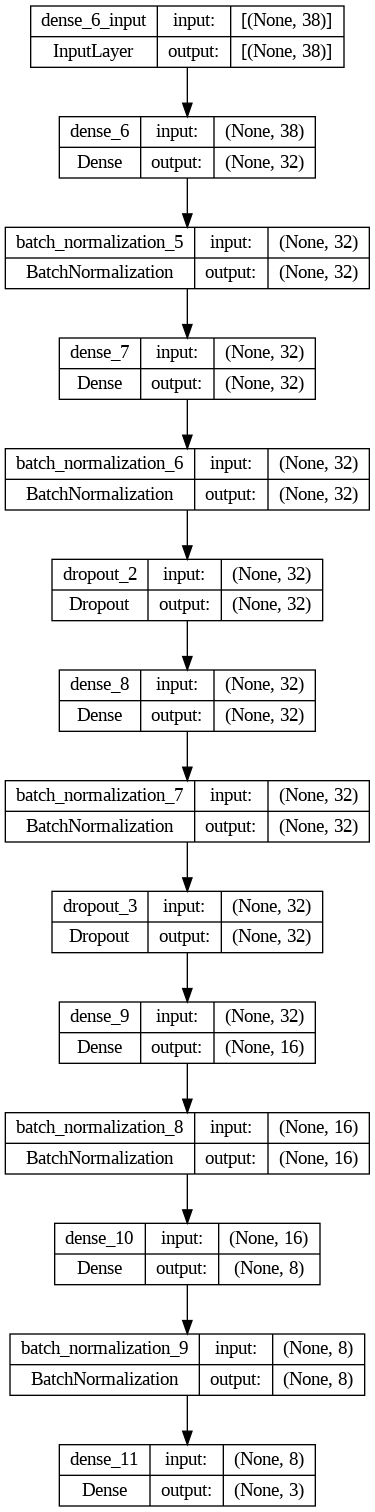

In [87]:
probabilities_pred = model.predict(test)
tf.keras.utils.plot_model(model, show_shapes=True)

### 2. XGBoost

In [88]:
xgb_params = {
 'num_class': 3,
 'n_estimators': 528,
 'learning_rate': 0.06542605284995028,
 'max_depth': 5,
 'subsample': 0.7109369692740082,
 'colsample_bytree': 0.13027270667695215,
 'min_child_weight': 1,
 'eval_metric': 'mlogloss', }

n_splits=10

stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_results = []

for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    xgb_model = XGBClassifier(**xgb_params )
    xgb_model.fit(X_train, y_train)

    y_val_pred_prob = xgb_model.predict_proba(X_val)
    y_pred = xgb_model.predict(X_val)

    f1 = f1_score(y_val, y_pred, average='weighted')
    logloss = log_loss(y_val, y_val_pred_prob)

    print(f'Fold {fold + 1}, Logarithmic Loss on Validation Set: {logloss}')
    print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
    print('-'*70)

    cv_results.append(logloss)

average_cv_result = np.mean(cv_results)
print(f'\nAverage Logarithmic Loss across {n_splits} folds: {average_cv_result}')

Fold 1, Logarithmic Loss on Validation Set: 0.41605370569505273
Fold 1, F1 Score on Validation Set: 0.8351390941013257
----------------------------------------------------------------------
Fold 2, Logarithmic Loss on Validation Set: 0.4589116158863795
Fold 2, F1 Score on Validation Set: 0.8113500307313812
----------------------------------------------------------------------
Fold 3, Logarithmic Loss on Validation Set: 0.3669589955727329
Fold 3, F1 Score on Validation Set: 0.8447309265254599
----------------------------------------------------------------------
Fold 4, Logarithmic Loss on Validation Set: 0.44930605826419423
Fold 4, F1 Score on Validation Set: 0.8164862326442406
----------------------------------------------------------------------
Fold 5, Logarithmic Loss on Validation Set: 0.4327512226043972
Fold 5, F1 Score on Validation Set: 0.8267370055332389
----------------------------------------------------------------------
Fold 6, Logarithmic Loss on Validation Set: 0.4109916

In [49]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.4 MB/s eta 0:00:00


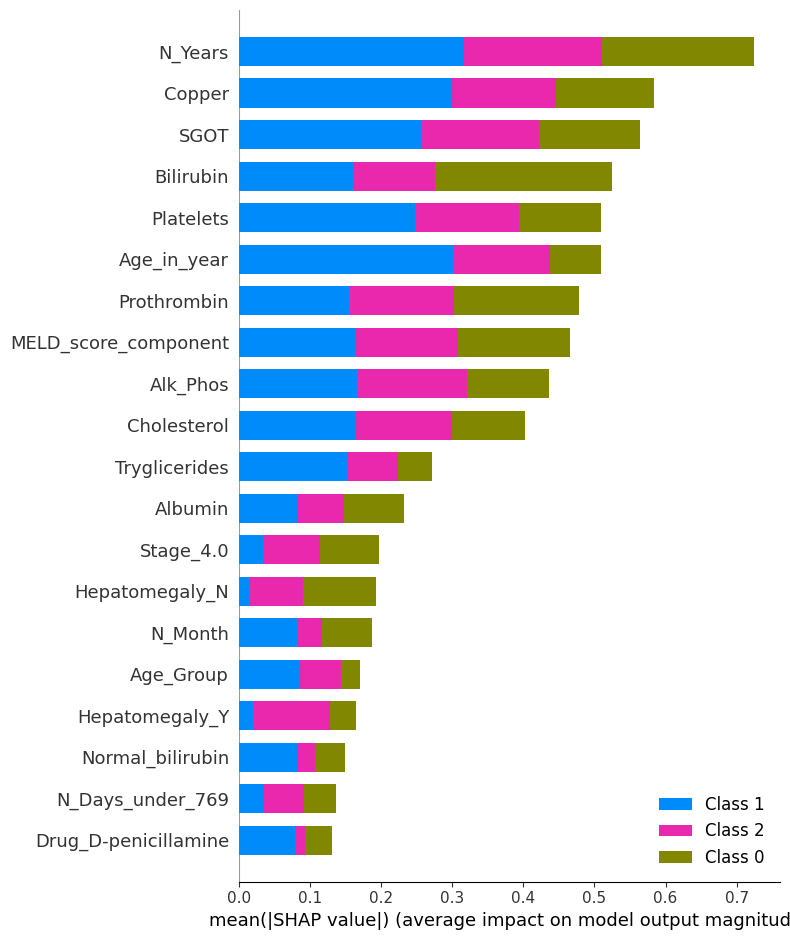

In [50]:
import shap

explainer = shap.Explainer(xgb_model)


shap_values = explainer.shap_values(X_train.iloc[:100, :])

# Summary plot of feature importance
shap.summary_plot(shap_values, X_train.iloc[:100, :])

### LGBM

In [89]:
"""
import lightgbm as lgb
import optuna

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

preds = lgb_model.predict(X_val)
y_pred_probs = lgb_model.predict_proba(X_val)

print('Log loss for LGBM Model: ', log_loss(y_val, y_pred_probs))

def objective(trial):
    # Define the hyperparameters to be optimized
    params = {
       "objective": "multiclass",
        "num_class": len(set(y_train)),
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int('n_estimators', 300, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }
    # Build the CatBoost model
    optuna_lgbmodel = lgb.LGBMClassifier(**params,
                                         random_state=42,
                                         verbose=-1)

    optuna_lgbmodel.fit(X_train, y_train)
    y_pred_probs = optuna_lgbmodel.predict_proba(X_val)
    logloss = log_loss(y_val, y_pred_probs)

    return logloss

# Create the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best Log Loss:', study.best_value)
"""

'\nimport lightgbm as lgb\nimport optuna\n\nlgb_model = lgb.LGBMClassifier()\nlgb_model.fit(X_train, y_train)\n\npreds = lgb_model.predict(X_val)\ny_pred_probs = lgb_model.predict_proba(X_val)\n\nprint(\'Log loss for LGBM Model: \', log_loss(y_val, y_pred_probs))\n\ndef objective(trial):\n    # Define the hyperparameters to be optimized\n    params = {\n       "objective": "multiclass",\n        "num_class": len(set(y_train)),\n        "boosting_type": "gbdt",\n        "n_estimators": trial.suggest_int(\'n_estimators\', 300, 2000),\n        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),\n        "max_depth": trial.suggest_int("max_depth", 1, 15),\n        "subsample": trial.suggest_float("subsample", 0.05, 1.0), \n        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0), \n        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),\n    }\n    # Build the CatBoost model\n    optuna_lgbmodel = lgb.LGBMClassifier(**params,\

In [90]:
#params = study.best_params
params = {'n_estimators': 1395,
         'learning_rate': 0.014421315853767148,
         'max_depth': 6,
         'subsample': 0.4957117459475332,
         'colsample_bytree': 0.08336498592363806,
         'min_child_weight': 9
        }

lgbModel_2 = lgb.LGBMClassifier(**params, random_state=42)
lgbModel_2.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 7396, number of used features: 38
[LightGBM] [Info] Start training from score -0.470545
[LightGBM] [Info] Start training from score -3.328965
[LightGBM] [Info] Start training from score -1.080258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(colsample_bytree=0.08336498592363806,
               learning_rate=0.014421315853767148, max_depth=6,
               min_child_weight=9, n_estimators=1395, random_state=42,
               subsample=0.4957117459475332)

### Ensemble Voting

In [91]:
#convert the neural network into a normal classifier

#X_values = X.values
#y_values = y.values

#X_train, X_val, y_train, y_val = train_test_split(X_values, y_values, test_size=0.1, random_state=42)

keras_clf = KerasClassifier(
                            create_nn_model,
                            epochs=200,
                            batch_size=8,
                            callbacks=callbacks_list,
                            loss='sparse_categorical_crossentropy',
                            validation_split=0.1,
                            verbose=True)

In [92]:
vclassifier = VotingClassifier(estimators = [('xgb', xgb_model), ('lgb', lgbModel_2)],
                            voting='soft',
                            weights = [0.85, 0.15])

vclassifier.fit(X_train, y_train)

preds = vclassifier.predict_proba(X_val)
val_loss = log_loss(y_val, preds)
print(f"Test set log loss: {val_loss}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 7396, number of used features: 38
[LightGBM] [Info] Start training from score -0.470545
[LightGBM] [Info] Start training from score -3.328965
[LightGBM] [Info] Start training from score -1.080258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [93]:
probabilities_pred = vclassifier.predict_proba(test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


## 🤖 7. Submission

In [94]:
sample['Status_C'] = probabilities_pred[:,0]
sample['Status_CL'] = probabilities_pred[:,1]
sample['Status_D'] = probabilities_pred[:,2]

display(sample)

sample.to_csv('submission.csv',index=False)

,id,Status_C,Status_CL,Status_D
0,7905,0.402449,0.013248,0.584302
1,7906,0.442640,0.107122,0.450238
2,7907,0.012963,0.004349,0.982688
3,7908,0.981829,0.003272,0.014900
4,7909,0.819309,0.087495,0.093196
...,...,...,...,...
5266,13171,0.904358,0.059773,0.035870
5267,13172,0.966989,0.005575,0.027437
5268,13173,0.895686,0.023234,0.081080
5269,13174,0.988452,0.006328,0.005220


In [96]:
model.save('model.keras')